In [ ]:
# ==============
# CONFIG
# ==============

import astrique_module
import pandas as pd

PREDICTOR1 = 'voicing'                    # first predictor column name
PREDICTOR2 = 'duration'                   # second predictor column name
FILENAME_COL = 'filename'                 # filename column name
LABEL_MAPPING = {'s': 0, 'z': 1}          # binary output label mapping

TARGET = 'answer_batch'                   # target column name
DATA_PATH = 'data/data.csv'               # sound info data file path
PARTICIPANT_CSV_DIR = 'data/participants' # participant CSV directory
PROCESSED_PATH = 'data_processed.csv'     # processed data file path; empty string to disable

INIT_RANDOM_SAMPLES = 10                  # initial random samples to collect
MIN_ITERATIONS = 30                       # minimum number of iterations
CLEANSER_FREQUENCY = 0                    # insert a high-certainty sample every nth iteration to prevent participant fatigue (irrelevant for virtual agents); 0 to disable
MODEL_CERTAINTY_CUTOFF = 0.95             # stopping certainty threshold
PARTICIPANT_TO_MODEL = 'p03'              # participant ID to simulate

In [8]:
# ==============
# VIRTUAL AGENT FUNCTIONS
# ==============

def query_participant_classification(filename):
    """
    Queries a virtual agent for a classification of a given sample
    """
    # look into the participant's answer lookup table - PARTICIPANT_CSV_DIR/PARTICIPANT_TO_MODEL.csv
    # return the real class based on LABEL_MAPPING
    participant_answers = pd.read_csv(PARTICIPANT_CSV_DIR + '/' + PARTICIPANT_TO_MODEL + '.csv')
    real_answer = participant_answers[participant_answers[FILENAME_COL] == filename][TARGET].values[0]
    return LABEL_MAPPING[real_answer]

Iteration 1: Random sampling
Iteration 2: Random sampling
Iteration 3: Random sampling
Iteration 4: Random sampling
Iteration 5: Random sampling
Iteration 6: Random sampling
Iteration 7: Random sampling
Iteration 8: Random sampling
Iteration 9: Random sampling
Iteration 10: Random sampling
Iteration 11: Uncertainty	Certainty: 0.5137411159531451
Iteration 12: Uncertainty	Certainty: 0.5165363872661052
Iteration 13: Uncertainty	Certainty: 0.5658686653874953
Iteration 14: Uncertainty	Certainty: 0.5445711034402945
Iteration 15: Uncertainty	Certainty: 0.512222634957407
Iteration 16: Uncertainty	Certainty: 0.6096302207556366
Iteration 17: Uncertainty	Certainty: 0.9732709992393703
Iteration 18: Uncertainty	Certainty: 0.9808878843872922
Iteration 19: Uncertainty	Certainty: 0.6035136929662583
Iteration 20: Uncertainty	Certainty: 0.964080558500416
Iteration 21: Uncertainty	Certainty: 0.9893632146648227
Iteration 22: Uncertainty	Certainty: 0.8351036184294376
Iteration 23: Uncertainty	Certainty: 0.

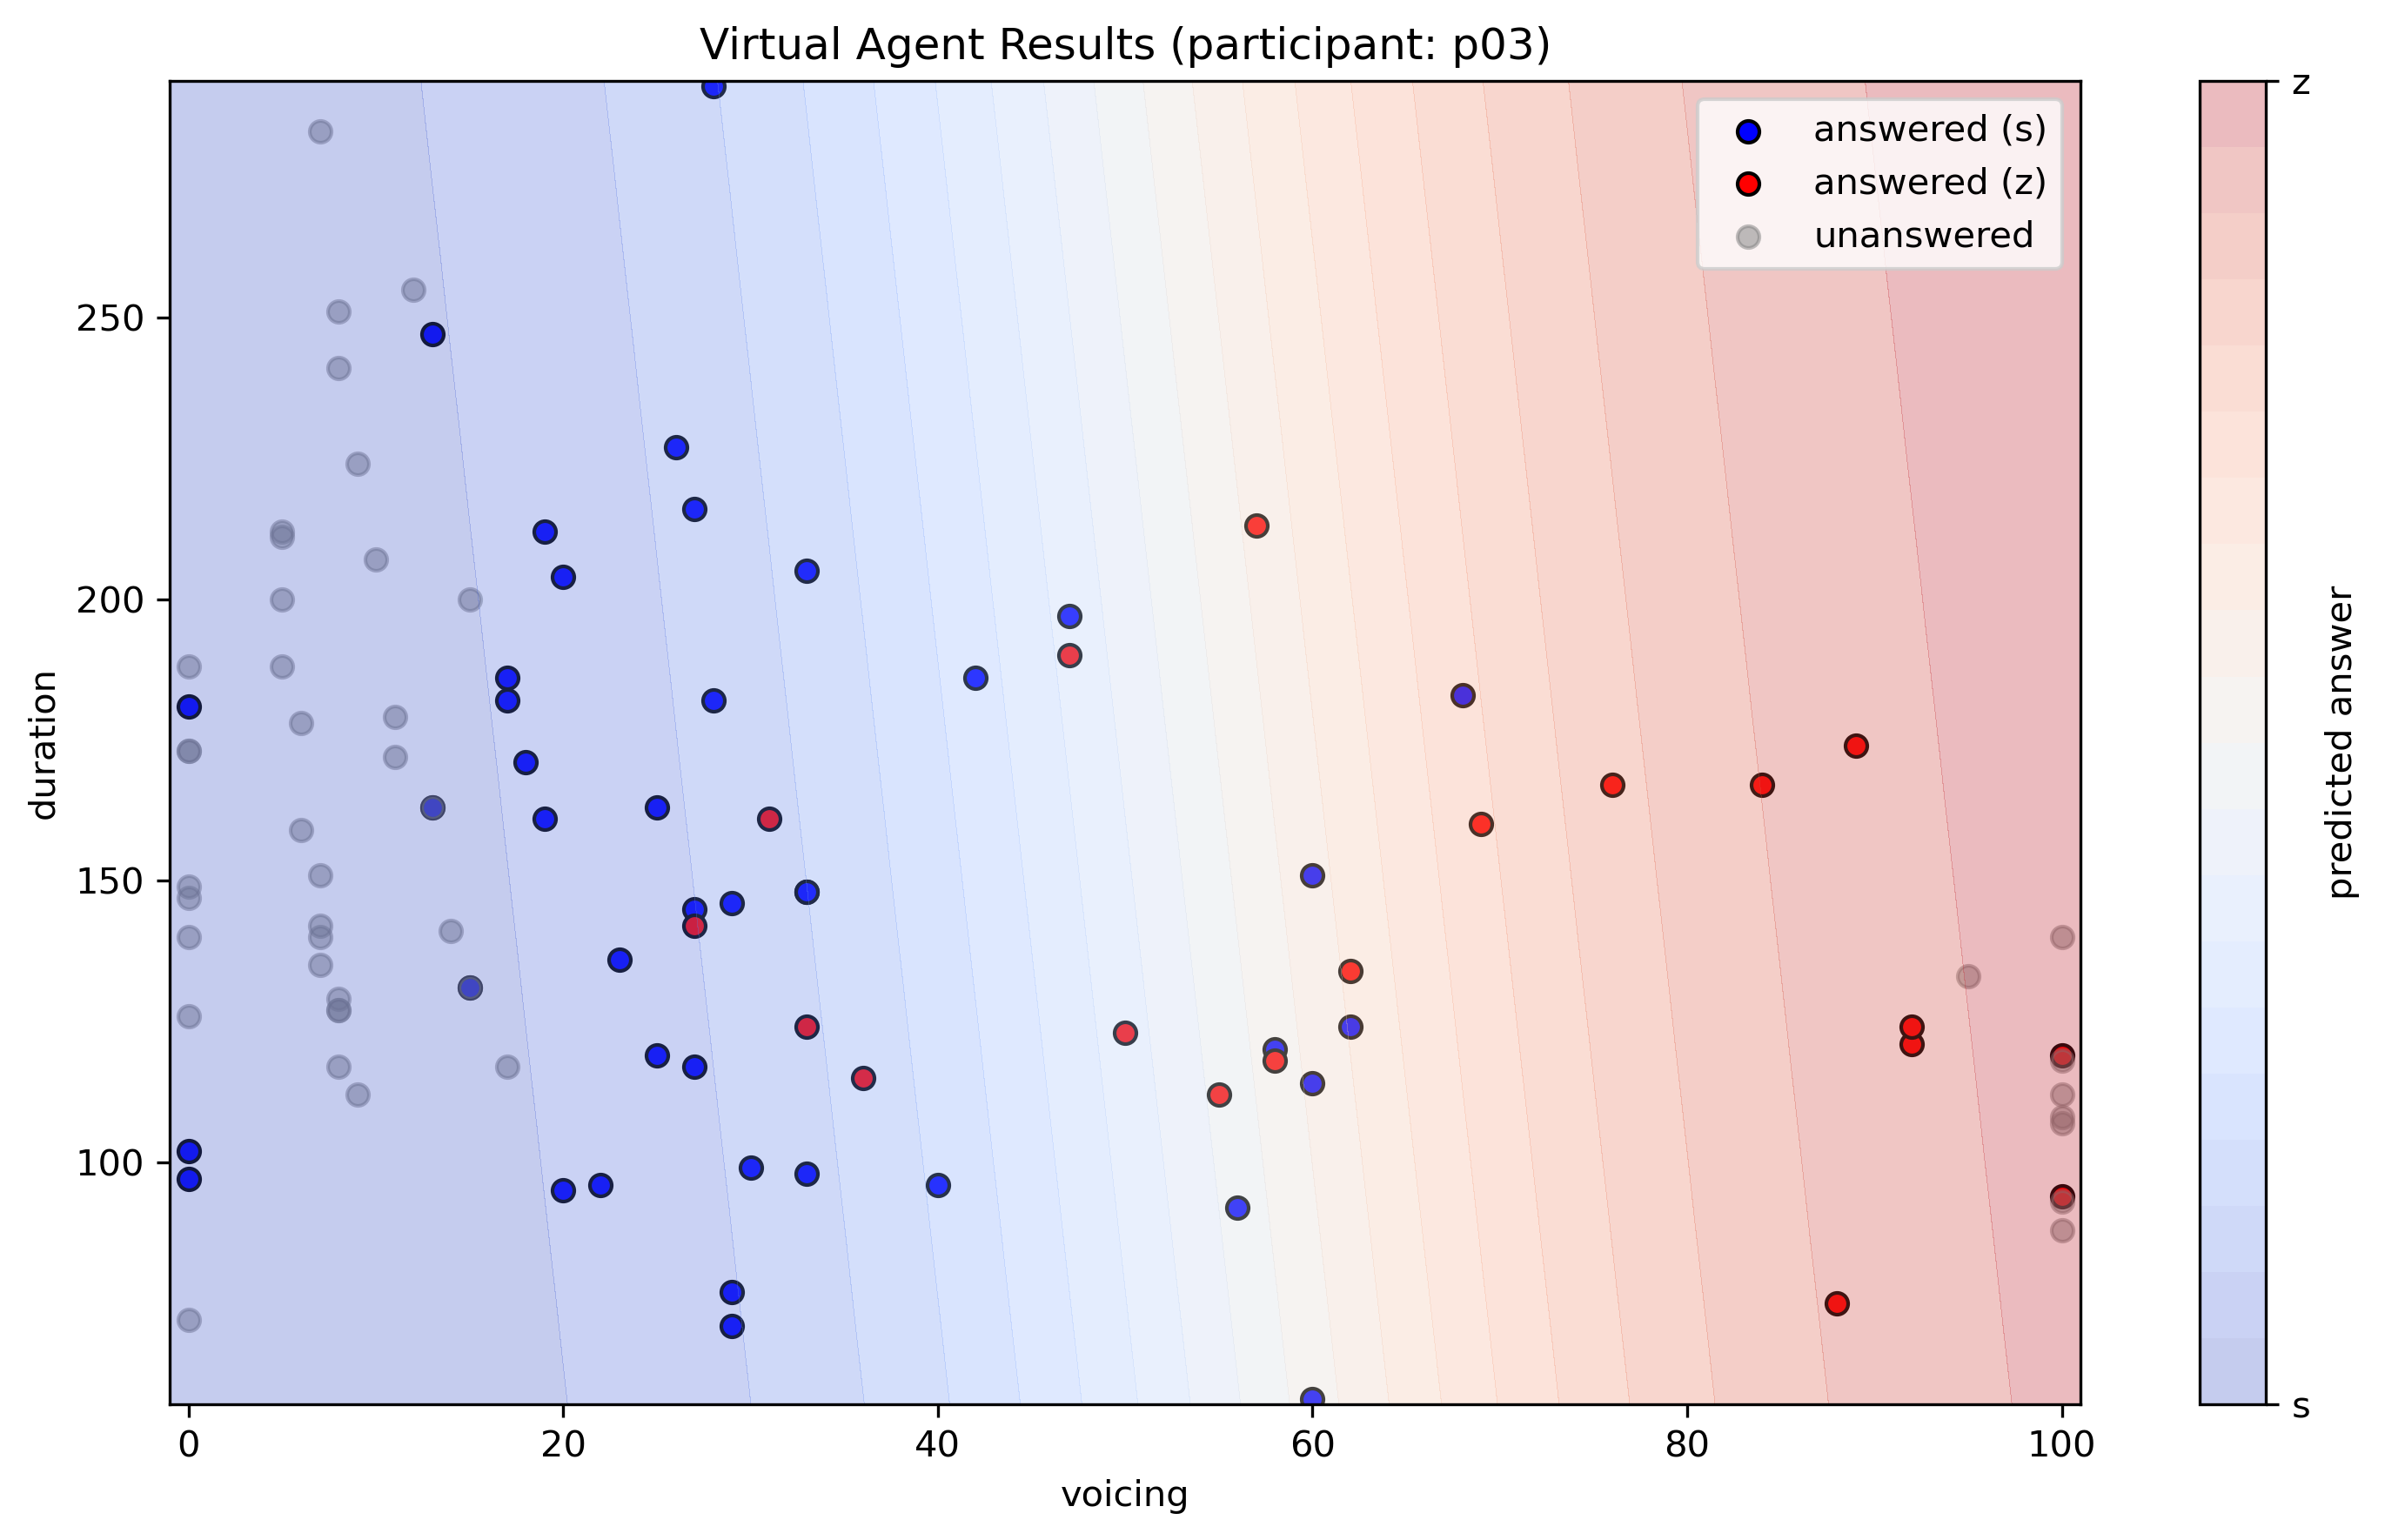

Processed data saved to data_processed.csv


In [9]:
# ==============
# MAIN EXECUTION
# ==============

# create stimuli dataframe
stimuli = pd.read_csv(DATA_PATH)

astrique_module.initialize_dataframe(stimuli)

# initial random sampling with class balance
collected_classes = set()

iteration = 1 # starting at 1 for human readability
while iteration <= INIT_RANDOM_SAMPLES or len(collected_classes) < 2:
    print(f"Iteration {iteration}: Random sampling")

    # select a random stimulus where real class is unknown
    sample = stimuli[stimuli['participant_classification'].isna()].sample(1)

    # get classification, querying filename
    classification = int(query_participant_classification(sample[FILENAME_COL].values[0]))
    
    collected_classes.add(classification)

    # update row in dataframe
    idx = stimuli[FILENAME_COL] == sample[FILENAME_COL].values[0]
    stimuli.loc[idx, 'classification_order'] = iteration
    stimuli.loc[idx, 'classification_type'] = 'random'
    stimuli.loc[idx, 'participant_classification'] = classification

    iteration += 1

random_samples = iteration - 1

# train initial model
model = astrique_module.train_model(stimuli, PREDICTOR1, PREDICTOR2)

while True:
    # retrain model to get up-to-date predictions on remaining unlabeled samples
    model = astrique_module.train_model(stimuli, PREDICTOR1, PREDICTOR2)

    # get updated unanswered subset
    unanswered = stimuli[stimuli['participant_classification'].isna()]
    
    # check stopping condition
    below_cutoff = unanswered['prediction_certainty'] < MODEL_CERTAINTY_CUTOFF
    if below_cutoff.sum() == 0 and iteration >= MIN_ITERATIONS:
        print("Stopping active learning: all predictions above certainty threshold "
              f"({MODEL_CERTAINTY_CUTOFF}) and minimum iterations met ({MIN_ITERATIONS}).")
        break

    # select next sample using uncertainty sampling (with optional cleanser)
    sample, sample_type = astrique_module.get_sample(unanswered, iteration, CLEANSER_FREQUENCY, random_samples)

    # query real classification
    classification = int(query_participant_classification(sample[FILENAME_COL].values[0]))

    # update row in dataframe
    idx = stimuli[FILENAME_COL] == sample[FILENAME_COL].values[0]
    stimuli.loc[idx, 'classification_order'] = iteration
    stimuli.loc[idx, 'classification_type'] = sample_type
    stimuli.loc[idx, 'participant_classification'] = classification

    iteration += 1

# evaluate model
astrique_module.evaluate_model(stimuli, FILENAME_COL, query_participant_classification)

plot_title = f'Virtual Agent Results (participant: {PARTICIPANT_TO_MODEL})'

# plot the results
astrique_module.plot_results(stimuli, model, plot_title, PREDICTOR1, PREDICTOR2, LABEL_MAPPING)

# export data if desired
astrique_module.export_data(stimuli, PROCESSED_PATH)